In [1]:
import neural_net
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from scipy.ndimage import convolve

In [2]:
def load_dataset(root_dir):
    """
    Recursively parse the LGG MRI dataset.
    Returns a list of dictionaries:
    [
      {
        "image_path": "...",
        "mask_path": "...",
        "image": np.ndarray,
        "mask": np.ndarray
      },
      ...
    ]
    """
    data = []

    # Walk through all subdirectories
    for subdir, dirs, files in os.walk(root_dir):
        # Only consider tif files
        tifs = [f for f in files if f.endswith(".tif")]

        # Create mapping: index -> file
        image_files = {f.replace("_mask", ""): f for f in tifs if "_mask" not in f}
        mask_files  = {f.replace("_mask", ""): f for f in tifs if "_mask" in f}

        # Pair image + mask files
        for key in sorted(image_files.keys()):
            if key in mask_files:
                img_path = os.path.join(subdir, image_files[key])
                mask_path = os.path.join(subdir, mask_files[key])

                # Load arrays
                img = np.array(Image.open(img_path))
                mask = np.array(Image.open(mask_path))

                data.append({
                    "image_path": img_path,
                    "mask_path": mask_path,
                    "image": img,
                    "mask": mask
                })

    return data

In [3]:
root = "/home/tyler/projects/UNet/data/lgg-mri-segmentation/kaggle_3m"
dataset = load_dataset(root)
print(f"Loaded {len(dataset)} image/mask pairs.\n")
# Example: print one sample
sample = dataset[0]
print("Image:", sample["image_path"])
print("Mask:", sample["mask_path"])
print("Image shape:", sample["image"].shape)
print("Mask shape:", sample["mask"].shape)
# ---- Split into tumor / non-tumor ----
tumor = []
no_tumor = []

for item in dataset:
    if np.any(item["mask"] > 0):
        tumor.append(item)
    else:
        no_tumor.append(item)

print("Tumor images:", len(tumor))
print("No-tumor images:", len(no_tumor))

images = np.stack([
    np.transpose(item["image"], (2, 0, 1))  # (H,W,C) → (C,H,W)
    for item in tumor 
]).astype(np.float32)                        # final shape [N, 3, 256, 256]
images = images / 255.0
mean = images.mean(axis=(0, 2, 3), keepdims=True)  # per-channel mean
std = images.std(axis=(0, 2, 3), keepdims=True)    # per-channel std
images = (images - mean) / (std + 1e-7)
masks = np.stack([
    item["mask"]                             # (H,W)
    for item in tumor 
]).astype(np.float32)    
if masks.max() > 1.0:
    masks = masks / 255.0
# final shape [N, 256, 256]
images = np.ascontiguousarray(images.copy())
masks = np.ascontiguousarray(masks.copy())
N, C, H, W = images.shape
shape = [float(N), float(C), float(H), float(W)]

Loaded 3929 image/mask pairs.

Image: /home/tyler/projects/UNet/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_1.tif
Mask: /home/tyler/projects/UNet/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_1_mask.tif
Image shape: (256, 256, 3)
Mask shape: (256, 256)
Tumor images: 1373
No-tumor images: 2556


In [4]:
def visualizeImage(image):
    num_channels = image.shape[0]
    if(num_channels > 1):
        fig, axes = plt.subplots(1, num_channels)
        for i in range(num_channels):
            axes[i].imshow(image[i, :, :], cmap='gray')
            axes[i].set_title(f'Channel {i+1}')
        plt.show()
    else:
        fig, axes = plt.subplots(1)
        axes.imshow(image[0, :, :], cmap='gray')
        axes.set_title(f'Channel {1}')
        plt.show()        


(3, 256, 256)


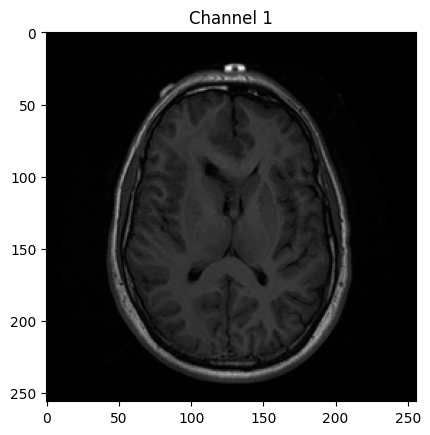

(1, 256, 256)


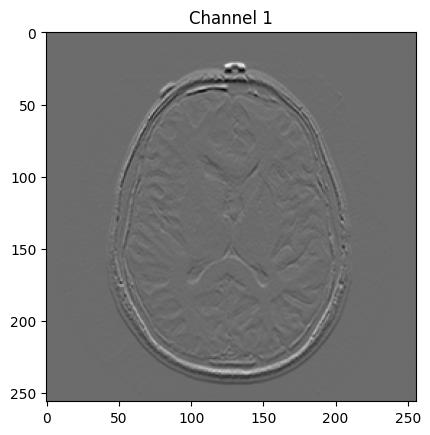

In [5]:
#get original image
image = images[0]
print(image.shape)
#visualize image
visualizeImage(image[:1,:,:])
#transform image using convolution

#get kernel
kernel = np.array([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]])
#apply transform
convolved_image = cv2.filter2D(image[:1,:,:], -1, kernel)
print(convolved_image.shape)
#visualize image
visualizeImage(convolved_image)

#train


In [6]:

from neural_net import NeuralNet
from neural_net import LayerType
from neural_net import LayerDesc
from neural_net import ActivationType
from neural_net import Convolution


In [7]:

Convolution2D = Convolution()
kernel = np.array([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]])
kernel = np.reshape(kernel, (1,1,3,3))
bias = np.array([0])
print(kernel.shape)
convolved_image = Convolution2D.convolution2D(image[:1,:,:], kernel,bias, 1, 1)


(1, 1, 3, 3)
in convolution
out of convolution


In [8]:
convolved_image = np.reshape(convolved_image,(1,256,256))

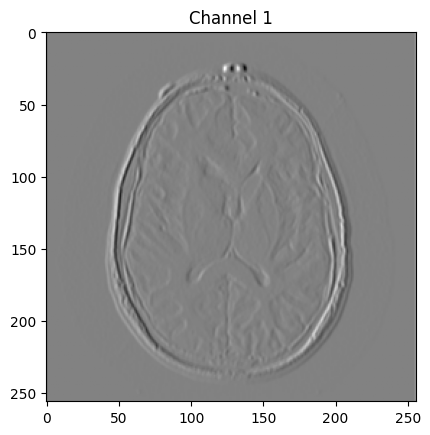

In [9]:

visualizeImage(convolved_image)


In [ ]:
kernel = np.array([[0.1, -0.3, 0.4], [-0.07, 0.04, 0.5], [-0.4, -4, 0.6]])
kernel = np.reshape(kernel, (1, 1, 3, 3))
bias = np.array([0])

weights = Convolution2D.train(image[:1, :, :], convolved_image,kernel, bias, 1, 1)

: 

starting train
asserts passed
pointers allocated
t: 0
0.109353 -0.288944 0.411783 
-0.0597564 0.0522798 0.51273 
-0.38899 -3.98697 0.613053 
t: 1
0.127684 -0.267224 0.434966 
-0.0396555 0.0764372 0.537798 
-0.367349 -3.9613 0.638777 
t: 2
0.154261 -0.235602 0.468804 
-0.010452 0.111687 0.574442 
-0.33582 -3.92375 0.676427 
t: 3
0.188013 -0.19519 0.51221 
0.0267546 0.156887 0.621551 
-0.295484 -3.87546 0.724921 
t: 4
0.227575 -0.147415 0.563791 
0.070556 0.210569 0.677698 
-0.247726 -3.81784 0.782865 
t: 5
0.271321 -0.0939658 0.621894 
0.119281 0.270996 0.741193 
-0.194189 -3.75261 0.848611 
t: 6
0.317429 -0.0367421 0.684663 
0.171052 0.336214 0.810135 
-0.136721 -3.68167 0.920305 
t: 7
0.363937 0.0222089 0.750094 
0.223846 0.404116 0.882474 
-0.0773118 -3.60708 0.995942 
t: 8
0.408806 0.080763 0.816108 
0.275567 0.472515 0.956079 
-0.0180259 -3.531 1.07345 
t: 9
0.449996 0.136788 0.880614 
0.32411 0.539215 1.02881 
0.0390639 -3.45556 1.15072 
t: 10
0.485527 0.188216 0.941585 
0.367433 

KeyboardInterrupt: 